In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as plt
import seaborn as sns
from pathlib import Path
import re

import os
import glob

## Get the County FIPS code across the U.S

FIPs code of cites/places is from the 2015 [Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2015.html#list-tab-790442341).

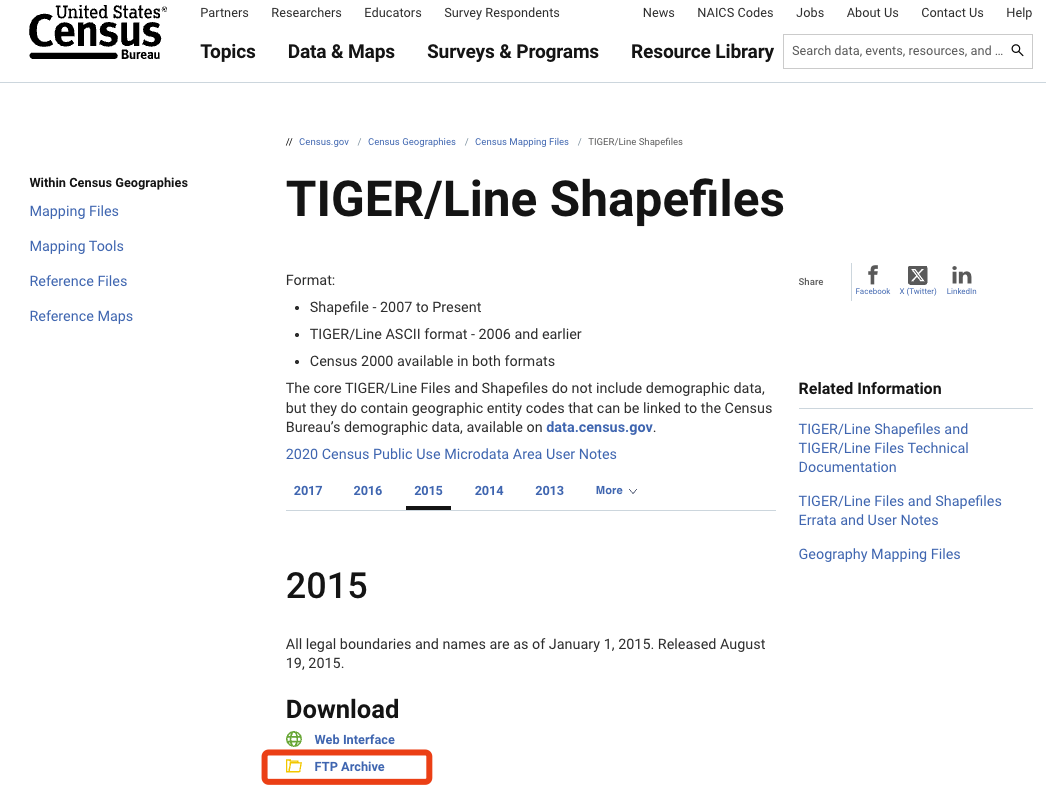

In [5]:
# ### 2015 US Places
# places_us = gpd.GeoDataFrame()

# for i in range(80):  # loop over FIPS codes 00–59
#     state = str(i).zfill(2)
#     try:
#         url = f"https://www2.census.gov/geo/tiger/TIGER2015/PLACE/tl_2015_{state}_place.zip"
#         places = gpd.read_file(url)
#         places_us = pd.concat([places_us, places], ignore_index=True)
#         print(f"Loaded state {state}: {len(places)} records")
#     except Exception as e:
#         print(f"Skip state {state}: {e}")
#         continue
    
# places_us.to_crs(epsg=4326, inplace=True)
# places_us.to_file('/Users/houpuli/Downloads/places_us_2015.geojson', driver='GeoJSON')
# places_us

In [2]:
places_us = gpd.read_file('/Users/houpuli/Downloads/places_us_2015.geojson')
places_us = places_us[["GEOID", "NAME", "NAMELSAD", "geometry"]]
places_us = places_us.to_crs(epsg=4326)
places_us

,GEOID,NAME,NAMELSAD,geometry
0,0125840,Fayette,Fayette city,"POLYGON ((-87.85507 33.70778, -87.85510 33.710..."
1,0105932,Berry,Berry town,"POLYGON ((-87.63910 33.66662, -87.63794 33.666..."
2,0132536,Gu-Win,Gu-Win town,"POLYGON ((-87.88577 33.95965, -87.88575 33.960..."
3,0146696,Margaret,Margaret town,"MULTIPOLYGON (((-86.46153 33.69044, -86.46100 ..."
4,0156400,Odenville,Odenville town,"MULTIPOLYGON (((-86.38406 33.72070, -86.37197 ..."
...,...,...,...,...
29304,7827000,Coral Bay,Coral Bay CDP,"POLYGON ((-64.73262 18.35238, -64.73248 18.352..."
29305,7828000,Cruz Bay,Cruz Bay CDP,"POLYGON ((-64.79980 18.32669, -64.79975 18.326..."
29306,7839700,Frederiksted Southeast,Frederiksted Southeast CDP,"POLYGON ((-64.88569 17.70194, -64.88555 17.702..."
29307,7865530,Red Hook,Red Hook CDP,"POLYGON ((-64.85760 18.32305, -64.85335 18.327..."


## Test for assign city fips to each block
Rule: 

- If a block falls within a city, assign the city’s FIPS code to the block (e.g., for Bessemer city: 0105980, where 01 is the state FIPS and 05980 is the city FIPS).
If it’s not within a city, assign "0000000", it will arise only for those situations such as spatial join does not work or no geometry at all.
- Create a map label value h based on the number in the map name. For example, fharent_1 → h = "1".
- Generate a sequence number for each block, starting from 0001, 0002, 0003, …
- Combine city FIPS + h + sequence number to create a unique global_id for each block.


Summary: the global id should looks like "Abcdefghijkl",  
where "ab" is the state FIPS code, "cdefg" is the city FIPS code, "h" is the number map for that city so fharent_1 would be "1", and "ijkl" would be the number block (beginning at "0001" and then "0002"...). So blocks for the Erie map fharent_2 would be 42240002XXXX).

In [7]:
map_path = "/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/Alabama/CV_adjusted/Bessemer_fharent_geo_all_adjusted.geojson"
block_gdf = gpd.read_file(map_path)
block_gdf = block_gdf.to_crs(places_us.crs)
block_gdf

,value,ind,color,area,geometry
0,1.0,1.0,Yellow,2616,None
1,NaN,NaN,Green,41391,"POLYGON ((-86.93510 33.40670, -86.93407 33.406..."
2,NaN,NaN,Green,10048,"POLYGON ((-86.94698 33.40248, -86.94629 33.403..."
3,NaN,NaN,Green,2816,"POLYGON ((-86.94810 33.39341, -86.94779 33.393..."
4,NaN,NaN,Orange,13338,"POLYGON ((-86.94297 33.39361, -86.94197 33.393..."
...,...,...,...,...,...
456,NaN,NaN,Green,662,"POLYGON ((-86.93533 33.41850, -86.93508 33.418..."
457,NaN,NaN,Green,4349,"POLYGON ((-86.93741 33.40660, -86.93691 33.406..."
458,NaN,NaN,Green,13211,"POLYGON ((-86.93679 33.40621, -86.93567 33.405..."
459,NaN,NaN,Yellow,21401,"POLYGON ((-86.92458 33.42927, -86.92422 33.429..."


In [8]:
block_id = block_gdf.sjoin(places_us, how="left", predicate="within")
block_id['GEOID'] = block_id['GEOID'].fillna("0000000")
map_label = Path(map_path).stem
map_label

'Bessemer_fharent_geo_all_adjusted'

In [9]:
block_id['sequence'] = (block_id.reset_index().index + 1).astype(str).str.zfill(4)
block_id

,value,ind,color,area,geometry,index_right,GEOID,NAME,NAMELSAD,sequence
0,1.0,1.0,Yellow,2616,None,NaN,0000000,NaN,NaN,0001
1,NaN,NaN,Green,41391,"POLYGON ((-86.93510 33.40670, -86.93407 33.406...",352.0,0105980,Bessemer,Bessemer city,0002
2,NaN,NaN,Green,10048,"POLYGON ((-86.94698 33.40248, -86.94629 33.403...",352.0,0105980,Bessemer,Bessemer city,0003
3,NaN,NaN,Green,2816,"POLYGON ((-86.94810 33.39341, -86.94779 33.393...",352.0,0105980,Bessemer,Bessemer city,0004
4,NaN,NaN,Orange,13338,"POLYGON ((-86.94297 33.39361, -86.94197 33.393...",352.0,0105980,Bessemer,Bessemer city,0005
...,...,...,...,...,...,...,...,...,...,...
456,NaN,NaN,Green,662,"POLYGON ((-86.93533 33.41850, -86.93508 33.418...",352.0,0105980,Bessemer,Bessemer city,0457
457,NaN,NaN,Green,4349,"POLYGON ((-86.93741 33.40660, -86.93691 33.406...",352.0,0105980,Bessemer,Bessemer city,0458
458,NaN,NaN,Green,13211,"POLYGON ((-86.93679 33.40621, -86.93567 33.405...",352.0,0105980,Bessemer,Bessemer city,0459
459,NaN,NaN,Yellow,21401,"POLYGON ((-86.92458 33.42927, -86.92422 33.429...",254.0,0143336,Lipscomb,Lipscomb city,0460


In [10]:
m = re.search(r'fharent_(\d+)', map_label)
h = m.group(1) if m else '0'       # <- '0' when there is no number
h = h[-1]  
h

'0'

In [11]:
block_id['global_id'] = (block_id['GEOID'].astype(str) + str(h) + block_id['sequence'].astype(str))
block_id

,value,ind,color,area,geometry,index_right,GEOID,NAME,NAMELSAD,sequence,global_id
0,1.0,1.0,Yellow,2616,None,NaN,0000000,NaN,NaN,0001,000000000001
1,NaN,NaN,Green,41391,"POLYGON ((-86.93510 33.40670, -86.93407 33.406...",352.0,0105980,Bessemer,Bessemer city,0002,010598000002
2,NaN,NaN,Green,10048,"POLYGON ((-86.94698 33.40248, -86.94629 33.403...",352.0,0105980,Bessemer,Bessemer city,0003,010598000003
3,NaN,NaN,Green,2816,"POLYGON ((-86.94810 33.39341, -86.94779 33.393...",352.0,0105980,Bessemer,Bessemer city,0004,010598000004
4,NaN,NaN,Orange,13338,"POLYGON ((-86.94297 33.39361, -86.94197 33.393...",352.0,0105980,Bessemer,Bessemer city,0005,010598000005
...,...,...,...,...,...,...,...,...,...,...,...
456,NaN,NaN,Green,662,"POLYGON ((-86.93533 33.41850, -86.93508 33.418...",352.0,0105980,Bessemer,Bessemer city,0457,010598000457
457,NaN,NaN,Green,4349,"POLYGON ((-86.93741 33.40660, -86.93691 33.406...",352.0,0105980,Bessemer,Bessemer city,0458,010598000458
458,NaN,NaN,Green,13211,"POLYGON ((-86.93679 33.40621, -86.93567 33.405...",352.0,0105980,Bessemer,Bessemer city,0459,010598000459
459,NaN,NaN,Yellow,21401,"POLYGON ((-86.92458 33.42927, -86.92422 33.429...",254.0,0143336,Lipscomb,Lipscomb city,0460,014333600460


In [12]:
block_id = block_id.drop(columns=['index_right', 'sequence'])
block_id

,value,ind,color,area,geometry,GEOID,NAME,NAMELSAD,global_id
0,1.0,1.0,Yellow,2616,None,0000000,NaN,NaN,000000000001
1,NaN,NaN,Green,41391,"POLYGON ((-86.93510 33.40670, -86.93407 33.406...",0105980,Bessemer,Bessemer city,010598000002
2,NaN,NaN,Green,10048,"POLYGON ((-86.94698 33.40248, -86.94629 33.403...",0105980,Bessemer,Bessemer city,010598000003
3,NaN,NaN,Green,2816,"POLYGON ((-86.94810 33.39341, -86.94779 33.393...",0105980,Bessemer,Bessemer city,010598000004
4,NaN,NaN,Orange,13338,"POLYGON ((-86.94297 33.39361, -86.94197 33.393...",0105980,Bessemer,Bessemer city,010598000005
...,...,...,...,...,...,...,...,...,...
456,NaN,NaN,Green,662,"POLYGON ((-86.93533 33.41850, -86.93508 33.418...",0105980,Bessemer,Bessemer city,010598000457
457,NaN,NaN,Green,4349,"POLYGON ((-86.93741 33.40660, -86.93691 33.406...",0105980,Bessemer,Bessemer city,010598000458
458,NaN,NaN,Green,13211,"POLYGON ((-86.93679 33.40621, -86.93567 33.405...",0105980,Bessemer,Bessemer city,010598000459
459,NaN,NaN,Yellow,21401,"POLYGON ((-86.92458 33.42927, -86.92422 33.429...",0143336,Lipscomb,Lipscomb city,014333600460


## Final function for automately accessing dropbox file and assigning unique ID to each block

In [3]:
import geopandas as gpd
import re
from pathlib import Path

def process_all_geojson(main_dir: str, places_us):
    """
    Batch process all geojson files under Map_files for each state:
    1. Traverse the CV_adjusted folder in each state directory;
    2. For each geojson file, generate global_id;
    3. Overwrite and save the file.
    """
    main_path = Path(main_dir)
    
    # Traverse all state subfolders
    for state_folder in main_path.iterdir():
        if not state_folder.is_dir():
            continue

        cv_folder = state_folder / "CV_adjusted"
        if not cv_folder.exists():
            continue

        # Traverse all geojson files in CV_adjusted
        for geo_file in cv_folder.glob("*.geojson"):
            print(f"Processing: {geo_file}")

            try:
                # Read and convert to unified CRS
                block_gdf = gpd.read_file(geo_file)
                block_gdf = block_gdf.to_crs(places_us.crs)

                # Spatial join
                block_id = block_gdf.sjoin(places_us, how="left", predicate="within")
                block_id['GEOID'] = block_id['GEOID'].fillna("0000000")

                # Extract number from map_label if present
                map_label = geo_file.stem
                m = re.search(r'fharent_(\d+)', map_label)
                h = m.group(1) if m else '0'
                h = h[-1]  # Use only the last digit

                # Generate sequence numbers
                block_id['sequence'] = (block_id.reset_index().index + 1).astype(str).str.zfill(4)

                # Generate global_id
                block_id['global_id'] = (block_id['GEOID'].astype(str) + str(h) + block_id['sequence'].astype(str))

                # Drop helper columns
                block_id = block_id.drop(columns=['index_right', 'sequence'], errors='ignore')

                # Overwrite and save
                block_id.to_file(geo_file, driver="GeoJSON")
                print(f"✅ Saved: {geo_file}")

            except Exception as e:
                print(f"❌ Error processing {geo_file}: {e}")

In [14]:
main_dir = "/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files"
process_all_geojson(main_dir, places_us)

Processing: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/Missouri/CV_adjusted/Springfield_fharent_geo_all_adjusted.geojson
✅ Saved: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/Missouri/CV_adjusted/Springfield_fharent_geo_all_adjusted.geojson
Processing: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/Missouri/CV_adjusted/StJoseph_fharent_1_geo_all_adjusted.geojson
✅ Saved: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/Missouri/CV_adjusted/StJoseph_fharent_1_geo_all_adjusted.geojson
Processing: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/New Hampshire/CV_adjusted/Nashua_fharent_geo_all_adjusted.geojson
✅ Saved: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/New Hampshire/CV_adjusted/Nashua_fharent_geo_all_adjusted.geojson
Processing: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/New Hampshire/CV_adjusted/Concord_fharent_geo_all_adjusted.geojson
✅ Saved: /Users/houpuli/Redlining Lab

/opt/anaconda3/envs/houpu_py/lib/python3.9/site-packages/geopandas/io/file.py:612: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


✅ Saved: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/Virginia/CV_adjusted/Portsmouth_fharent_geo_all_adjusted.geojson
Processing: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/Washington/CV_adjusted/Seattle_fharent_2_geo_all_adjusted.geojson
✅ Saved: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/Washington/CV_adjusted/Seattle_fharent_2_geo_all_adjusted.geojson
Processing: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/Washington/CV_adjusted/Seattle_fharent_1_geo_all_adjusted.geojson
✅ Saved: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/Washington/CV_adjusted/Seattle_fharent_1_geo_all_adjusted.geojson
Processing: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/Washington/CV_adjusted/Seattle_fharent_4_geo_all_adjusted.geojson
✅ Saved: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/Washington/CV_adjusted/Seattle_fharent_4_geo_all_adjusted.geojson
Processing: /Users/houpuli/Redlining Lab

/opt/anaconda3/envs/houpu_py/lib/python3.9/site-packages/geopandas/io/file.py:612: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


✅ Saved: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/West Virginia/CV_adjusted/Morgantown_fharent_2_geo_all_adjusted.geojson
Processing: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/West Virginia/CV_adjusted/Clarksburg_fharent_geo_all_adjusted.geojson
✅ Saved: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/West Virginia/CV_adjusted/Clarksburg_fharent_geo_all_adjusted.geojson
Processing: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/West Virginia/CV_adjusted/Charleston_fharent_1_geo_all_adjusted.geojson


/opt/anaconda3/envs/houpu_py/lib/python3.9/site-packages/geopandas/io/file.py:612: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


✅ Saved: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/West Virginia/CV_adjusted/Charleston_fharent_1_geo_all_adjusted.geojson
Processing: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/West Virginia/CV_adjusted/Martinsburg_fharent_geo_all_adjusted_modified.geojson
✅ Saved: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/West Virginia/CV_adjusted/Martinsburg_fharent_geo_all_adjusted_modified.geojson
Processing: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/West Virginia/CV_adjusted/Parkersburg_fharent_geo_all.geojson
✅ Saved: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/West Virginia/CV_adjusted/Parkersburg_fharent_geo_all.geojson
Processing: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/West Virginia/CV_adjusted/SouthParkersburg_fharent_geo_all_adjusted.geojson
✅ Saved: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/West Virginia/CV_adjusted/SouthParkersburg_fharent_geo_all_adjusted.g

In [15]:
map_path = "/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/Maps/Map_files/Wyoming/CV_adjusted/Cheyenne_fharent_all_adjusted_modified.geojson"
block_gdf = gpd.read_file(map_path)
block_gdf = block_gdf.to_crs(places_us.crs)
block_gdf

,FID,level_0,level_1,color,id,area,GEOID,NAME,NAMELSAD,global_id,geometry
0,0,0,42,null_color,43,345.903992,0000000,NaN,NaN,000000000001,"POLYGON ((-104.83840 41.13542, -104.83840 41.1..."
1,1,0,131,Red,132,6630.680176,5613900,Cheyenne,Cheyenne city,561390000002,"POLYGON ((-104.83170 41.14221, -104.83170 41.1..."
2,2,0,132,Orange,133,6547.140137,5613900,Cheyenne,Cheyenne city,561390000003,"POLYGON ((-104.83209 41.14242, -104.83376 41.1..."
3,3,0,229,Red,230,2316.959961,5613900,Cheyenne,Cheyenne city,561390000004,"POLYGON ((-104.82783 41.14286, -104.82813 41.1..."
4,4,0,236,null_color,237,152.574997,5613900,Cheyenne,Cheyenne city,561390000005,"POLYGON ((-104.82544 41.14804, -104.82544 41.1..."
...,...,...,...,...,...,...,...,...,...,...,...
615,615,0,0,Green,n6,459.523987,5613900,Cheyenne,Cheyenne city,561390000616,"POLYGON ((-104.80846 41.14662, -104.80857 41.1..."
616,616,0,0,Red,n7,0.000000,5613900,Cheyenne,Cheyenne city,561390000617,"POLYGON ((-104.83481 41.14511, -104.83534 41.1..."
617,617,0,0,Orange,n8,0.000000,5613900,Cheyenne,Cheyenne city,561390000618,"POLYGON ((-104.82702 41.14162, -104.82787 41.1..."
618,618,0,0,Red,n9,0.000000,5613900,Cheyenne,Cheyenne city,561390000619,"POLYGON ((-104.82522 41.14552, -104.82611 41.1..."
